In [1]:
# Celda para importar librerías, costantes, etc.
import tensorflow as tf
import pandas as pd
import numpy as np
import librosa
import mido
import math

from Mu_law_encoder import Mu_law_encoder
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes

from Mu_law_encoder import *
from matplotlib import pyplot as plt

In [2]:
PATH = '/Volumes/TheVault/Documentos UC/Documentos Universidad/4o Curso/2o Cuatrimestre/Trabajo de Fin de Grado/maestro-v3.0.0/'
plt.rcParams['text.usetex'] = True
def get_dataframe(path=PATH + 'maestro-v3.0.0.csv'):
    df = pd.read_csv(path)
    return df

def plot_wav(waves, title=None):
    wave = waves.flatten()
    plt.figure(figsize=(16, 6), dpi=200)
    plt.plot(wave)
    plt.xlim(0, len(wave))
    plt.ylim(min(wave) * 1.05, max(wave) * 1.05)
    if title is not None: plt.title(title)
    plt.show()

def split_wav(data, old_sampling_rate, new_sampling_rate):
    duration = librosa.get_duration(y=data, sr=old_sampling_rate)
    sampling_period = 1 / new_sampling_rate
    step = int(len(data) * sampling_period / duration)

    tail = len(data) % step
    if tail > 0: data = data[0:-tail]
    result = data.reshape(-1, step)

    return result

SAMPLING_RATE = 16000

def vectorize_wav(file, sampling_rate=SAMPLING_RATE, dir_path=PATH):
    data, sr = librosa.load(PATH + file, sr=sampling_rate)
    return np.array(data)

In [2]:
DPI = 300

df = get_dataframe()
df.head()

out_enc = Mu_law_encoder()

# Celda de ejemplo para plotear la diferencia entre la señal real y la aproximada
N_EXAMPLES = 200
OFFSET = 182000
wav_real = vectorize_wav(df['audio_filename'][0])
wav_aprox = out_enc.decode_series(out_enc.encode_series(wav_real))

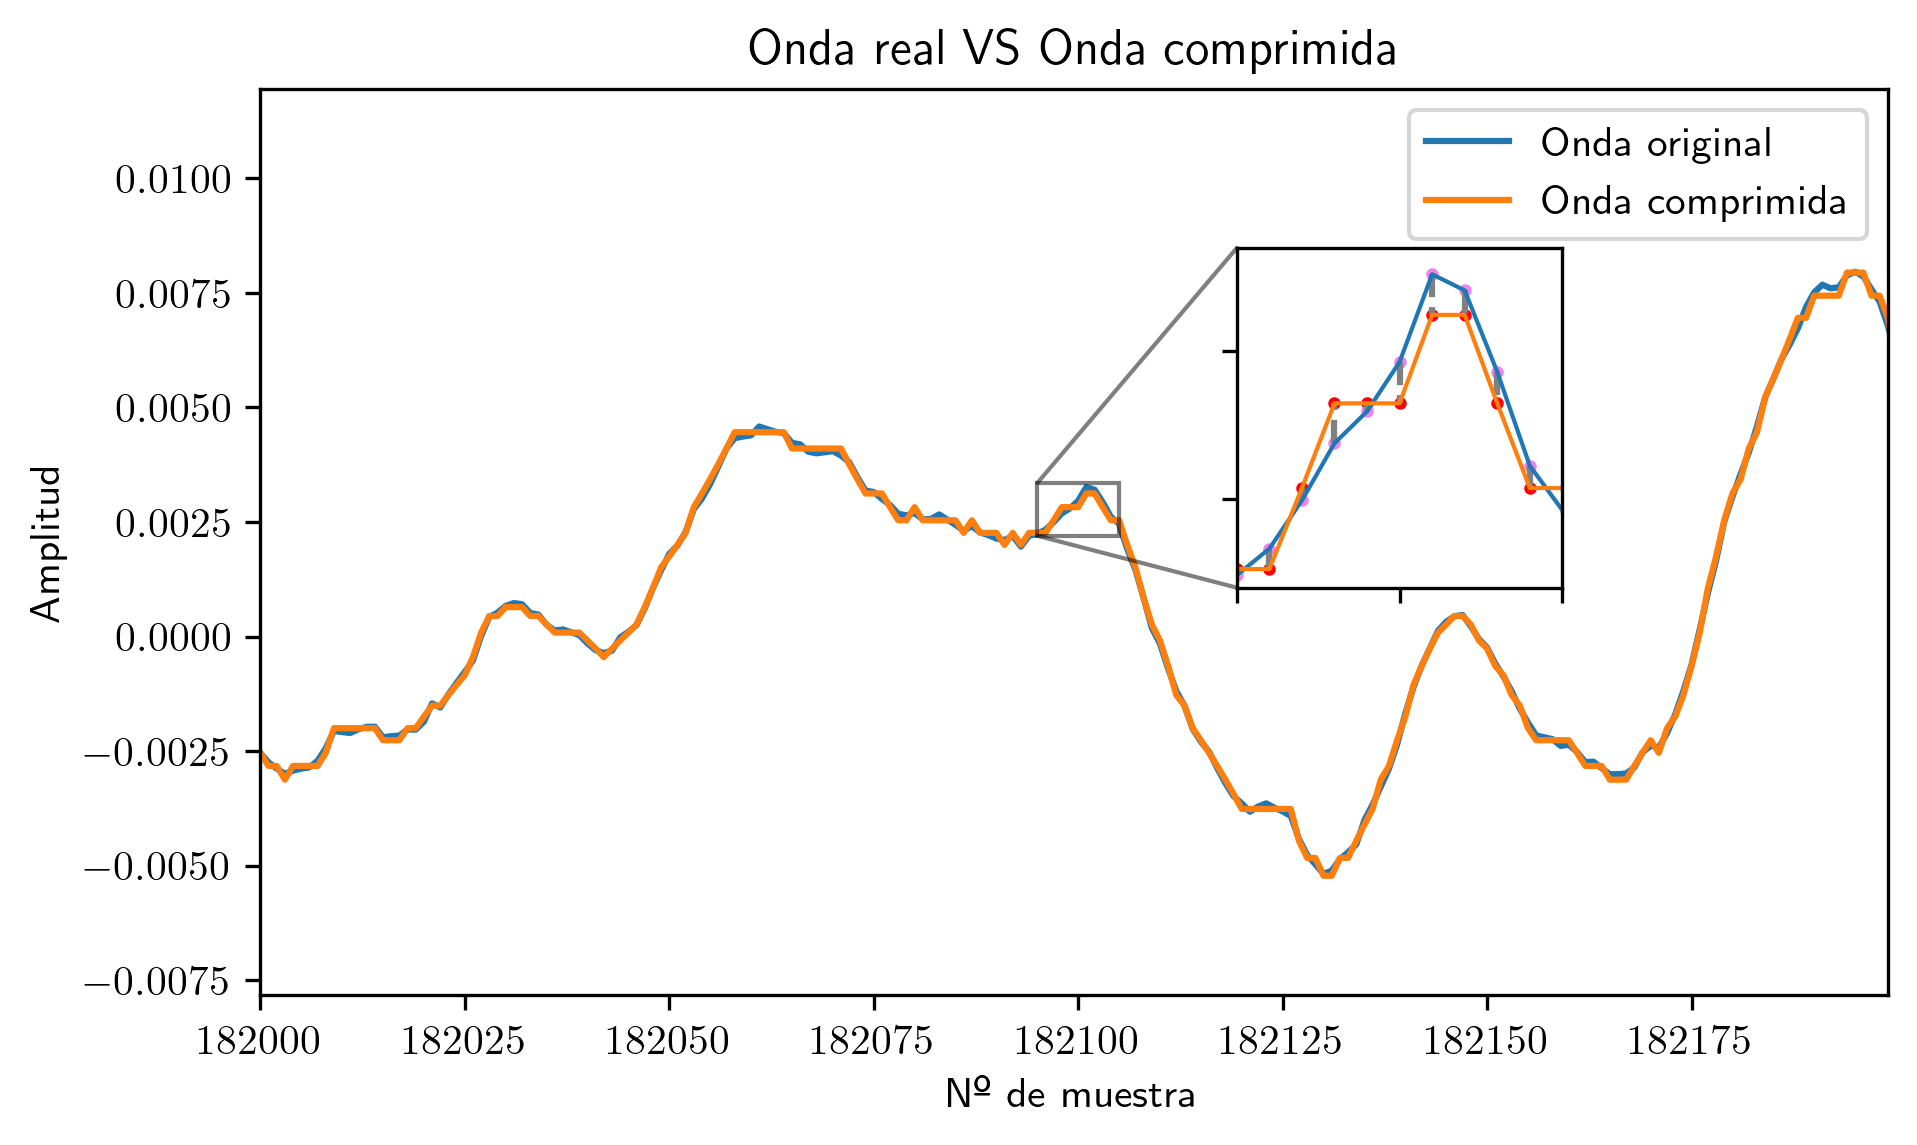

In [3]:
FILE=True

fig, ax = plt.subplots(figsize=[7, 4], dpi=DPI)

ax.plot(wav_real, label='Onda original')
ax.plot(wav_aprox, label='Onda comprimida')
ax.set_xlim([OFFSET,OFFSET+N_EXAMPLES-1])
ax.set_ylim([min([min(wav_real[OFFSET:OFFSET+N_EXAMPLES-1]), min(wav_aprox[OFFSET:OFFSET+N_EXAMPLES-1])])*1.5, max([max(wav_real[OFFSET:OFFSET+N_EXAMPLES-1]), max(wav_aprox[OFFSET:OFFSET+N_EXAMPLES-1])])*1.5])
plt.legend(loc="upper right")
plt.title('Onda real VS Onda comprimida')
ax.set_xlabel('Nº de muestra')
ax.set_ylabel('$\Delta$')


axins = ax.inset_axes([0.6, 0.45, 0.2, 0.375])

axins.plot((range(OFFSET+95, OFFSET+105), range(OFFSET+95, OFFSET+105)), (wav_real[OFFSET+95:OFFSET+105], wav_aprox[OFFSET+95:OFFSET+105]), c='grey', linestyle='--')

axins.plot(wav_real, linewidth=1)
axins.plot(wav_aprox, linewidth=1)
axins.scatter(range(OFFSET+95, OFFSET+105), wav_aprox[OFFSET+95:OFFSET+105], color='red', s=4)
axins.scatter(range(OFFSET+95, OFFSET+105), wav_real[OFFSET+95:OFFSET+105], color='violet', s=4)

axins.set_xticklabels([])
axins.set_yticklabels([])

x1, x2, y1, y2 = 50, 75, 0.5, 0.75
axins.set_xlim(OFFSET+95, OFFSET+105)
axins.set_ylim(0.0022, 0.00335)

axins.set_xticklabels([])
axins.set_yticklabels([])

ax.indicate_inset_zoom(axins, edgecolor="black")
plt.draw()

# Outputing the plot to an image or showning it
if FILE:
    plt.savefig('mulaw.png',  dpi=600)
else:
    plt.show()

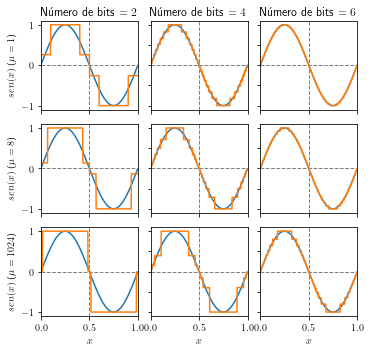

In [33]:
FILE=True

x = np.arange(0,1,0.001)
y = np.sin(2*math.pi*x)

ns_bits = [2, 4, 6]
mus = [1, 8, 1024]

figure, axes = plt.subplots(figsize=[5.25, 5], nrows=len(mus), ncols=len(ns_bits), )

for idx_bits, (n_bits) in enumerate(ns_bits, 0):
    for idx_mus, (mu) in enumerate(mus, 0):
        ax = axes[idx_mus, idx_bits]
        ax.plot(x, y)
        ax.axhline(y=0, color='grey', linestyle='--', linewidth=1)
        ax.axvline(x=0.5, color='grey', linestyle='--', linewidth=1)
        enc = Mu_law_encoder(mu=mu, n_bits=n_bits)
        y_prima = enc.decode_sample(enc.encode_series(y))
        ax.plot(x, y_prima)
        if idx_mus == 2:
            ax.set_xlabel('$x$')
        else:
            ax.set_xticklabels([])
        if idx_bits == 0:
            ax.set_ylabel('$sen(x)$ ($\mu=' + str(mu) + '$)')
        else:
            ax.yaxis.set_ticks([-1, -0.5, 0, 0.5, 1])
            ax.set_yticklabels([])
        ax.set_xlim([0,1])
        if idx_mus == 0:
            ax.set_title('Número de bits $= ' + str(n_bits) + '$')

figure.tight_layout(w_pad=0)

if FILE:
    plt.savefig('differentmus.png', dpi=600)
else:
    plt.show()

In [26]:
N_BITS = 8
N_LEVELS = (2 ** N_BITS) - 1

def q_enumerate(amp):

    min_amp, max_amp = -1, 1

    return math.ceil((N_LEVELS * (amp-min_amp)) / (max_amp - min_amp))


def q_denumerate(idx):

    min_amp, max_amp = -1, 1

    return ((max_amp - min_amp) * idx / N_LEVELS) + min_amp

q_denumerate(127)

-0.0039215686274509665

In [15]:
enc = Mu_law_encoder(mu=256, n_bits=8)

In [19]:
enc.encode_sample(1)

255

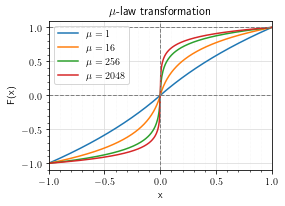

In [32]:
FILE=True

# Plotting sigmoid function
plt.figure(figsize=(4,2.75))
x = np.arange(-1, 1, 0.005)
y_1 = np.sign(x) * (np.log(1 + 1 * np.abs(x / 1))) / np.log(1 + 1)
y_16 = np.sign(x) * (np.log(1 + 16 * np.abs(x / 1))) / np.log(16+ 1)
y_256 = np.sign(x) * (np.log(1 + 256 * np.abs(x / 1))) / np.log(256 + 1)
y_2048 = np.sign(x) * (np.log(1 + 2048 * np.abs(x / 1))) / np.log(2048 + 1)
plt.plot(x, y_1, label='$\mu=1$')
plt.plot(x, y_16, label='$\mu=16$')
plt.plot(x, y_256, label='$\mu=256$')
plt.plot(x, y_2048, label='$\mu=2048$')
plt.legend(loc="upper left")
plt.xlabel('x')
plt.ylabel('F(x)')
plt.title('$\mu$-law transformation')
plt.xlim(-1, 1)
plt.ylim(-1.1, 1.1)
plt.axhline(y=0, color='grey', linestyle='--', linewidth=1)
plt.axhline(y=1, color='grey', linestyle='--', linewidth=1)
plt.axvline(x=0, color='grey', linestyle='--', linewidth=1)
plt.grid(axis='both', which='major', color='#DDDDDD', linewidth=0.8)
plt.grid(axis='x', which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.minorticks_on()
figure.tight_layout()

# Outputing the plot to an image or showning it
if FILE:
    plt.savefig('mufunction.png', bbox_inches='tight', dpi=600)
else:
    plt.show()

In [5]:
import tensorflow as tf

def calculate_receptive_field(n_blocks, n_layers):
    return sum([2 ** i for i in range(n_layers)] * n_blocks) - n_blocks + 1

In [18]:
# Parámetros que definen la arquitectura del modelo a crear por defecto en las llamadas a get_wavenet()
N_NOTES = 88
N_BITS = 256

# Parámetros de la arquitectura interna de la red
N_FILTERS = N_BITS
FILTER_WIDTH = 2
N_BLOCKS = 6
K_LAYERS = 10

# Números y longitudes de ejemplos de entrada, salida y local conditioning
INPUT_LEN = calculate_receptive_field(N_BLOCKS, K_LAYERS)
N_IN_CHANNELS = N_BITS
LC_LEN = 1
N_LC_CHANNELS = N_NOTES

# Dimensionalidad de input/output/local conditioning
INP_SHAPE = (INPUT_LEN, N_IN_CHANNELS)
OUT_SHAPE = INP_SHAPE
LC_SHAPE = (LC_LEN, N_LC_CHANNELS)

In [19]:
'''
    Método que devuelve el modelo de una wavenet implementada en tensorflow. Dicha red se construye
    de acuerdo a los parámetros de entrada.
'''
def get_wavenet(inp_shape=INP_SHAPE, out_shape=OUT_SHAPE, lc_shape=LC_SHAPE, n_filters=N_FILTERS, \
                filter_width=FILTER_WIDTH, k_layers=K_LAYERS, n_blocks=N_BLOCKS):

    dilation_rates_per_block = [2 ** i for i in range(k_layers)] * n_blocks

    # Input
    Input_seq = tf.keras.layers.Input(shape=inp_shape, dtype='float32', name='seq')
    x = Input_seq

    # Input Convolution
    x = tf.keras.layers.Conv1D(n_filters, filter_width, padding='same', activation='relu')(x)
    # padding='same' añade 0 en los bordes de la entrada para la convolución

    # Local Conditioning
    Input_lc = tf.keras.layers.Input(shape=lc_shape, dtype='float32', name='lc')
    lc = Input_lc

    # Local Conditioning Convolution
    lc = tf.keras.layers.Conv1D(n_filters, filter_width, padding='same', activation='relu')(lc)

    skips = []
    for dilation_rate in dilation_rates_per_block:

            x_conv = tf.keras.layers.Conv1D(n_filters, filter_width, padding='same', \
                                            dilation_rate=dilation_rate)(x)

            lc_conv = tf.keras.layers.Conv1D(n_filters, filter_width, padding='same', \
                                             dilation_rate=dilation_rate)(lc)

            tmp = tf.keras.layers.Add()([x_conv, lc_conv])

            # Multiplicamos las ramas de Filter y Gating
            z = tf.keras.layers.Multiply()([tf.keras.layers.Activation('tanh')(tmp),
                                            tf.keras.layers.Activation('sigmoid')(tmp)])

            z = tf.keras.layers.Conv1D(n_filters, filter_width, padding='same', \
                                       activation='relu')(z)

            # Residual connection
            x = tf.keras.layers.Add()([x, z])

            # Vamos añadiendo las 'Skip conections'
            skips.append(z)

            # x -> Residual
            # z -> Skip connections -> ...

    # Sumamos todas las skip connections y computamos el resto de funciones
    out = tf.keras.layers.Conv1D(n_filters, filter_width, padding='same')(tf.keras.layers.Add()(skips))
    out = tf.keras.layers.ReLU()(out)
    out = tf.keras.layers.Conv1D(n_filters, filter_width, padding='same')(out)
    out = tf.keras.layers.ReLU()(out)
    out = tf.keras.layers.Conv1D(out_shape[1], 1, padding='same')(out)
    out = tf.keras.layers.Softmax()(out)
    return tf.keras.models.Model(inputs=[Input_seq, Input_lc], outputs=out)

model = get_wavenet()
model.compile(tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 seq (InputLayer)               [(None, 6133, 256)]  0           []                               
                                                                                                  
 lc (InputLayer)                [(None, 1, 88)]      0           []                               
                                                                                                  
 conv1d_651 (Conv1D)            (None, 6133, 256)    131328      ['seq[0][0]']                    
                                                                                                  
 conv1d_652 (Conv1D)            (None, 1, 256)       45312       ['lc[0][0]']                     
                                                                                            

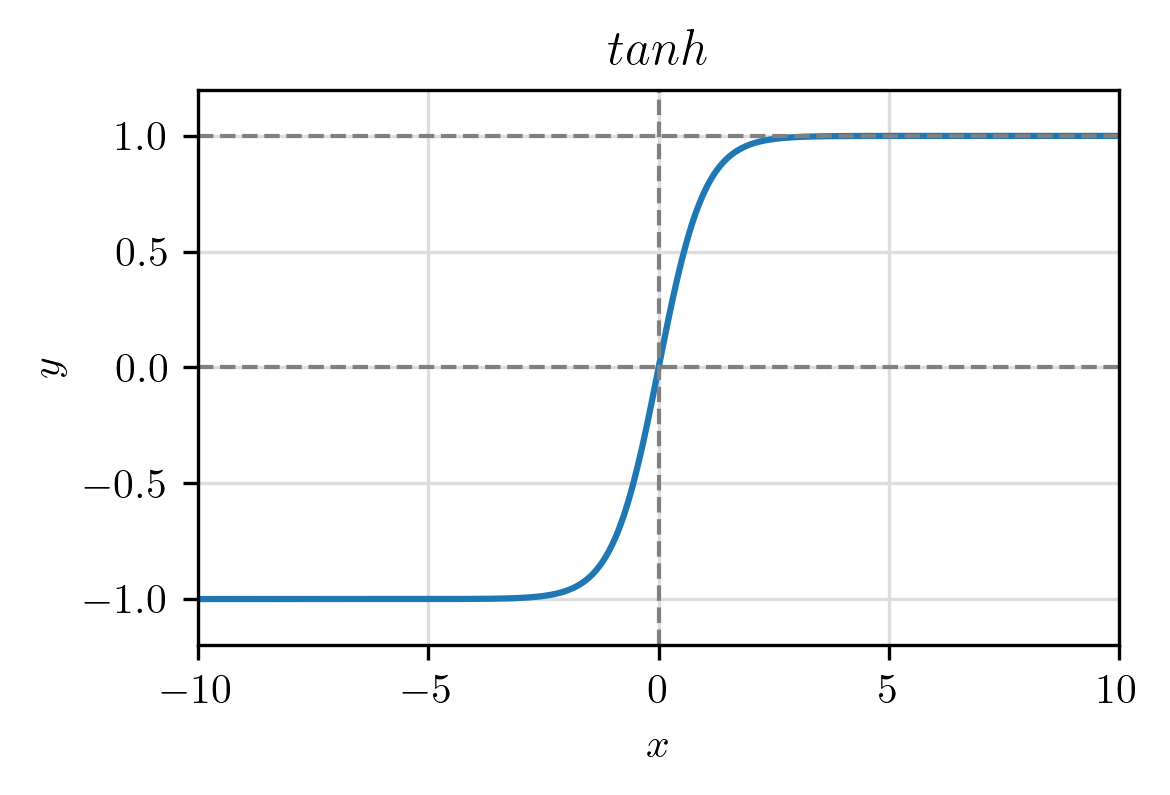

In [5]:
DPI=300
FILE=True
plt.rcParams['text.usetex'] = True
# Plotting sigmoid function
plt.figure(figsize=(4,2.75), dpi=DPI)
x = np.arange(-10, 10, 0.05)
y = (np.sinh(x)) / (np.cosh(x))
plt.plot(x, y)
plt.title('$tanh$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.xlim(-10, 10)
plt.ylim(min(y) -0.2, max(y) * 1.2)
plt.axhline(y=0, color='grey', linestyle='--', linewidth=1)
plt.axhline(y=1, color='grey', linestyle='--', linewidth=1)
plt.axvline(x=0, color='grey', linestyle='--', linewidth=1)
plt.grid(axis='both', which='major', color='#DDDDDD', linewidth=0.8)
plt.grid(axis='x', which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.minorticks_off()
plt.tight_layout()

# Outputing the plot to an image or showning it
if FILE:
    plt.savefig('tanh.png', dpi=600)
else:
    plt.show()

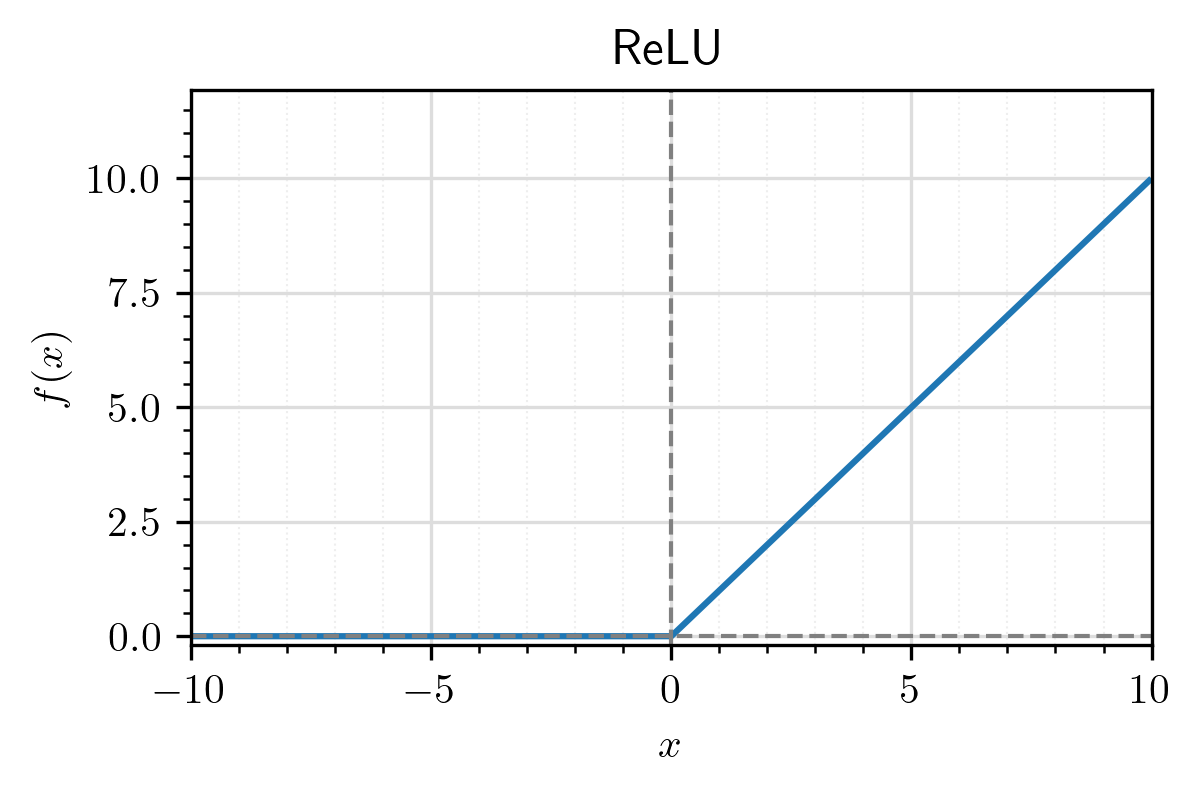

In [25]:
DPI=300
FILE=True
# Plotting sigmoid function
plt.figure(figsize=(4,2.75), dpi=DPI)
x = np.arange(-10, 10, 0.05)
y = [max(i) for i in zip([0] * x.shape[0], x)]
plt.plot(x, y)
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.title('ReLU')
plt.xlim(-10, 10)
plt.ylim(min(y) -0.2, max(y) * 1.2)
plt.axhline(y=0, color='grey', linestyle='--', linewidth=1)
plt.axvline(x=0, color='grey', linestyle='--', linewidth=1)
plt.grid(axis='both', which='major', color='#DDDDDD', linewidth=0.8)
plt.grid(axis='x', which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.minorticks_on()
plt.tight_layout()

# Outputing the plot to an image or showning it
if FILE:
    plt.savefig('relu.png', dpi=600)
else:
    plt.show()